In [2]:
import numpy as np
import scipy.sparse as sp
import ReservoirComputer3_2 as ReCom
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import ipywidgets as widgets
from scipy import stats
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import cm
import ReservoirPlot as resplt
import copy

In [18]:
def lorenz(u, *args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = alpha[0], alpha[1], alpha[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])


def plot_traj(traj, t_start=0, t_end=15000, xlim=300, ylim=300, zlim=300):
    fig = plt.figure(figsize=(15,9))
    ax = fig.gca(projection="3d")
    t_start = int(t_start)
    t_end = int(t_end)
    for i in range(len(traj)-1):
        u = traj[i]
        ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], "b-",
                markersize=2.0, alpha=0.5)
    u = traj[len(traj)-1]
    ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], "r-",
            markersize=2.0, alpha=0.5)
    for i in range(len(traj)):
        u = traj[i]
        ax.plot(u[t_end-1, 0], u[t_end-1, 1], u[t_end-1, 2], "ko",
                markersize=2.0, alpha=1.0)
    
    
    ax.set_xlim3d(-xlim, xlim)
    ax.set_ylim3d(-ylim, ylim)
    ax.set_zlim3d(0,zlim)

    
def evolve(RC, ics, t_points):
    ics = ics.copy()
    ics.append(RC.r_T)
    traj = np.zeros((len(ics), len(t_points), RC.d))
    
    for i in range(len(ics)):
        r0 = ics[i]
        PR_traj = integrate.odeint(RC.f_PR, r0, t_points)
        prediction = np.asarray([RC.W_out.dot(RC.q(p)) for p in PR_traj])
        traj[i,:,:] = prediction
    
    return traj 


def eta_epoch_grid_search(RC, train_data, t_points, t_listen, ics, eta_list, epochs_list, rule):
    predictions = np.zeros((eta_list.size ,epochs_list.size + 1 ,len(ics) + 1, t_points.size, RC.d))
    
    for i in range(eta_list.size):
        for j in range(epochs_list.size):
            print(eta_list[i], epochs_list[j])
            RC_copy = copy.deepcopy(RC)
            
            if rule == 'synaptic':
                RC_copy.eta_s = eta_list[i]
                RC_copy.epochs_s = epochs_list[j]
                RC_copy.SP_train(train_data, t_points_training, t_listen, reset_M=False)
            else:
                RC_copy.eta_i = eta_list[i]
                RC_copy.epochs_i = epochs_list[j]
                RC_copy.IP_train(train_data, t_points_training, t_listen, reset_M=False)
                
            training_traj = RC_copy.train(train_data, t_points_training, t_listen)
            pert_traj = evolve(RC_copy, ics, t_points)
            predictions[i, j,:,:,:] = pert_traj

    return predictions

In [9]:
T_train = 100
T_predict = 150
dt = 0.01
alpha = (8.0/3.0, 28.0, 10.0)
x0 = np.asarray([1.0, 1.0, 1.0])
t_points_training = np.linspace(0, T_train, int(T_train/dt))
t_points_prediction = np.linspace(0, T_predict, int(T_predict/dt))
train_data = integrate.odeint(lorenz, x0, t_points_training, args=alpha)
val_data = integrate.odeint(lorenz, train_data[-1], t_points_prediction, args=alpha)

Wall time: 52.5 s


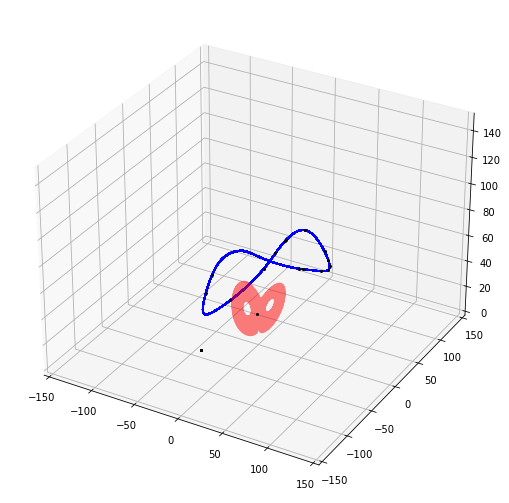

In [10]:
%%time
RC = ReCom.IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=0, epochs_i=0, eta_s=1e-6, epochs_s=10)
training_traj = RC.train(train_data, t_points_training, t_listen=5000)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))
trajectories = evolve(RC, ics, t_points_prediction)
plot_traj(trajectories, t_start=1000, t_end=15000, xlim=150, ylim=150, zlim=150)

In [13]:
%%time
RC.SP_train(train_data, t_points_training, t_listen=5000)
ah_train_traj = RC.train(train_data, t_points_training, t_listen=5000)

Wall time: 21.1 s


Wall time: 29.1 s


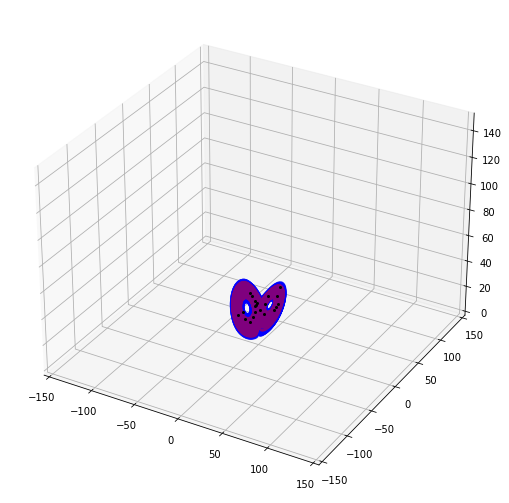

In [14]:
%%time
trajectories = evolve(RC, ics, t_points_prediction)
plot_traj(trajectories, t_start=1000, t_end=15000, xlim=150, ylim=150, zlim=150)

## Synaptic Plasticity - Intrinsic Plasticity:

In [19]:
# Grid search for optimal eta, epoch values
eta_list = np.asarray([1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
epochs_list = np.arange(1, 11)

In [20]:
RC = ReCom.IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=0, epochs_i=0, eta_s=1e-6, epochs_s=10)
RC.SP_train(train_data, t_points_training, t_listen=5000)

In [21]:
%%time
trajectories_sp_ip = eta_epoch_grid_search(RC, 
                                     train_data, 
                                     t_points_prediction, 
                                     5000, 
                                     ics, 
                                     eta_list, 
                                     epochs_list, 
                                     rule='intrinsic')

1e-09 1
1e-09 2
1e-09 3
1e-09 4
1e-09 5
1e-09 6
1e-09 7
1e-09 8
1e-09 9
1e-09 10
1e-08 1
1e-08 2
1e-08 3
1e-08 4
1e-08 5
1e-08 6
1e-08 7
1e-08 8
1e-08 9
1e-08 10
1e-07 1
1e-07 2
1e-07 3
1e-07 4
1e-07 5
1e-07 6
1e-07 7
1e-07 8
1e-07 9
1e-07 10
1e-06 1
1e-06 2
1e-06 3
1e-06 4
1e-06 5
1e-06 6
1e-06 7
1e-06 8
1e-06 9
1e-06 10
1e-05 1
1e-05 2
1e-05 3
1e-05 4
1e-05 5
1e-05 6
1e-05 7
1e-05 8
1e-05 9
1e-05 10
0.0001 1
0.0001 2
0.0001 3
0.0001 4
0.0001 5
0.0001 6
0.0001 7
0.0001 8
0.0001 9
0.0001 10
0.001 1
0.001 2
0.001 3
0.001 4
0.001 5


C:\Users\foxda\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.001 6
0.001 7
0.001 8
0.001 9
0.001 10
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.01 10
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.1 10
1.0 1
1.0 2
1.0 3
1.0 4
1.0 5
1.0 6
1.0 7
1.0 8
1.0 9
1.0 10
Wall time: 1h 16min 40s


In [22]:
%store trajectories_sp_ip

Stored 'trajectories_sp_ip' (ndarray)


In [25]:
%matplotlib inline
@widgets.interact(i=(0, 9, 1), j=(0, 9, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=0, t_start=1000, t_end=15000, xlim=50, ylim=50, zlim=50):
    fig = plt.figure(figsize=(15,9))  
    plot_traj(trajectories_sp_ip[i,j], t_start, t_end, xlim, ylim, zlim)
    
    print("Eta = " + str(eta_list[i]))
    print("Epoch = " + str(epochs_list[j]))

interactive(children=(IntSlider(value=0, description='i', max=9), IntSlider(value=0, description='j', max=9), …

In [39]:
RC = ReCom.IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=1e-5, epochs_i=5, eta_s=1e-6, epochs_s=10)

In [40]:
%%time
train_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction = RC.predict(t_points_prediction)

Wall time: 3 s


In [41]:
%%time
RC.SP_train(train_data, t_points_training, t_listen=5000)
train_traj_sp = RC.train(train_data, t_points_training, t_listen=5000)
prediction_sp = RC.predict(t_points_prediction)

Wall time: 22 s


In [42]:
%%time
RC.IP_train(train_data, t_points_training, t_listen=5000, reset_M=False)
train_traj_sp_ip = RC.train(train_data, t_points_training, t_listen=5000)
prediction_sp_ip = RC.predict(t_points_prediction)

Wall time: 13.1 s


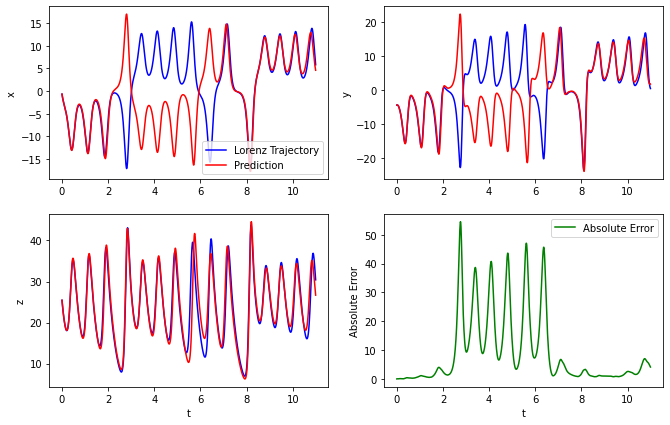

In [43]:
resplt.plot_short_pred(val_data, prediction, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)

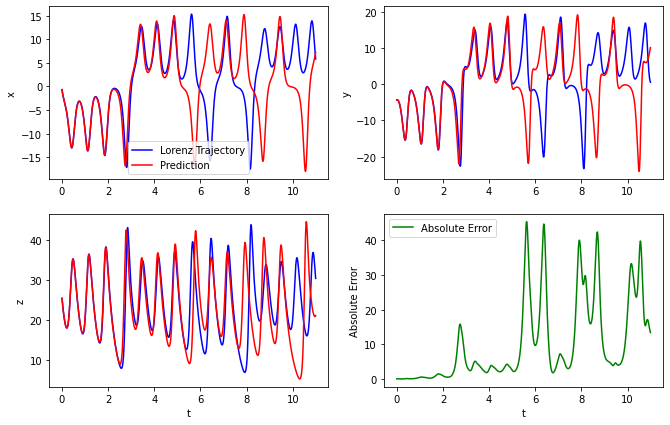

In [45]:
resplt.plot_short_pred(val_data, prediction_sp, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)

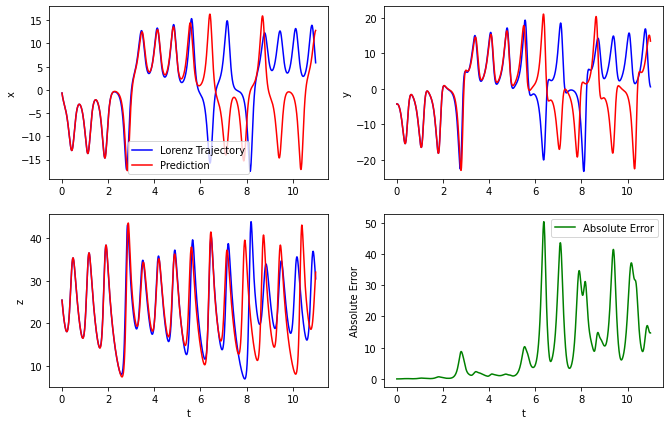

In [46]:
resplt.plot_short_pred(val_data, prediction_sp_ip, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)

## Intrinsic Plasticity - Synaptic Plasticity:

In [47]:
RC = ReCom.IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=1e-5, eta_s=0, epochs_i=5, epochs_s=0)
RC.IP_train(train_data, t_points_training, t_listen=5000)

In [48]:
%%time
trajectories_2 = eta_epoch_grid_search(RC, 
                                     train_data, 
                                     t_points_prediction, 
                                     5000, 
                                     ics, 
                                     eta_list, 
                                     epochs_list, 
                                     rule='synaptic')

1e-09 1
1e-09 2
1e-09 3
1e-09 4
1e-09 5
1e-09 6
1e-09 7
1e-09 8
1e-09 9
1e-09 10
1e-08 1
1e-08 2
1e-08 3
1e-08 4
1e-08 5
1e-08 6
1e-08 7
1e-08 8
1e-08 9
1e-08 10
1e-07 1
1e-07 2
1e-07 3
1e-07 4
1e-07 5
1e-07 6
1e-07 7
1e-07 8
1e-07 9
1e-07 10
1e-06 1
1e-06 2
1e-06 3
1e-06 4
1e-06 5
1e-06 6
1e-06 7
1e-06 8
1e-06 9
1e-06 10
1e-05 1
1e-05 2
1e-05 3
1e-05 4
1e-05 5
1e-05 6
1e-05 7
1e-05 8
1e-05 9
1e-05 10
0.0001 1
0.0001 2
0.0001 3
0.0001 4
0.0001 5
0.0001 6
0.0001 7
0.0001 8
0.0001 9
0.0001 10
0.001 1
0.001 2
0.001 3
0.001 4
0.001 5
0.001 6
0.001 7
0.001 8
0.001 9
0.001 10
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.01 10
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.1 10
1.0 1


C:\Users\foxda\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1.0 2
1.0 3
1.0 4
1.0 5
1.0 6
1.0 7
1.0 8
1.0 9
1.0 10
Wall time: 3h 22min 56s


In [49]:
%matplotlib inline
@widgets.interact(i=(0, 9, 1), j=(0, 9, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=0, t_start=1000, t_end=15000, xlim=50, ylim=50, zlim=50):
    fig = plt.figure(figsize=(15,9))  
    plot_traj(trajectories_2[i,j], t_start, t_end, xlim, ylim, zlim)
    
    print("Eta = " + str(eta_list[i]))
    print("Epoch = " + str(epochs_list[j]))

interactive(children=(IntSlider(value=0, description='i', max=9), IntSlider(value=0, description='j', max=9), …

In [71]:
RC = ReCom.IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=1e-5, epochs_i=5, eta_s=1e-7, epochs_s=4)

In [72]:
RC.IP_train(train_data, t_points_training, t_listen=5000, reset_M=False)

In [73]:
RC.SP_train(train_data, t_points_training, t_listen=5000, reset_M=False)

In [74]:
train_traj_sp_ip = RC.train(train_data, t_points_training, t_listen=5000)
prediction_sp_ip = RC.predict(t_points_prediction)

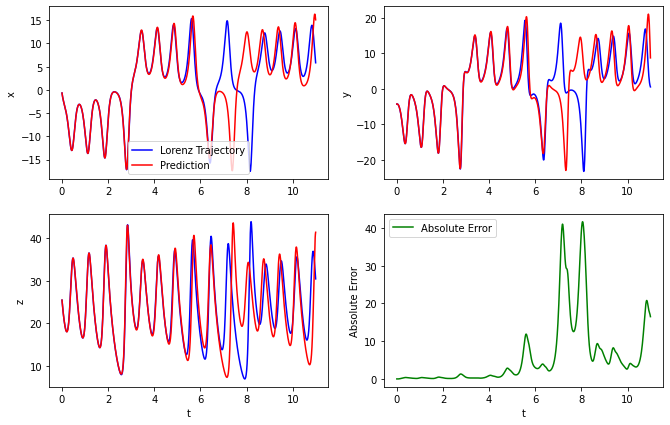

In [75]:
resplt.plot_short_pred(val_data, prediction_sp_ip, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)

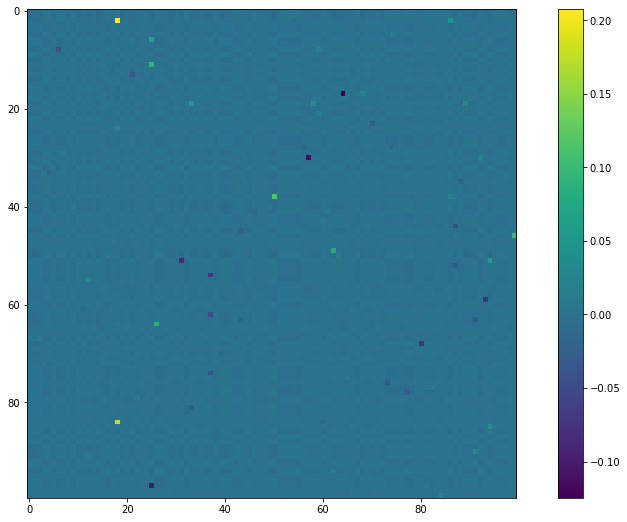

In [57]:
plt.figure(figsize=(15,9))
plt.imshow(RC.M.todense().transpose())
plt.colorbar()

In [58]:
RC.a

array([0.1247503 , 0.81280676, 0.15311109, 0.15337176, 0.14079014,
       0.21113479, 0.64440253, 0.16529716, 0.13505977, 0.54642489,
       0.30306807, 0.06707911, 0.15769234, 0.13465127, 0.29973409,
       0.11194225, 0.31231348, 0.04332717, 1.0622693 , 0.12465432,
       0.10308352, 0.674222  , 0.1430962 , 0.04061098, 0.44672355,
       0.68611858, 0.84573117, 0.25583498, 0.04363839, 0.88045929,
       0.0362956 , 0.48136067, 0.47844181, 0.96529848, 0.14309044,
       0.1179543 , 0.13513745, 0.45122592, 0.11402229, 0.13694305,
       0.42651436, 0.11699315, 0.18914192, 0.12261548, 0.04146523,
       0.4098878 , 0.12136254, 0.06822403, 0.06862921, 0.12507795,
       0.54148436, 0.14725568, 0.12093089, 0.12180603, 0.11240035,
       0.29714113, 0.05181993, 0.98792672, 0.90151429, 0.12693992,
       0.13373161, 0.08159479, 0.5890704 , 0.1146752 , 0.92905288,
       0.03623884, 0.05951157, 0.25049602, 0.20030323, 0.14869106,
       0.15589333, 0.07041118, 0.97420754, 0.16646356, 0.13168

(array([48., 18.,  8.,  6.,  4.,  3.,  2.,  4.,  5.,  2.]),
 array([0.03623884, 0.1469242 , 0.25760956, 0.36829493, 0.47898029,
        0.58966566, 0.70035102, 0.81103638, 0.92172175, 1.03240711,
        1.14309248]),
 <BarContainer object of 10 artists>)

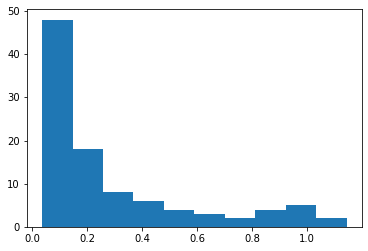

In [67]:
plt.hist(RC.a)

(array([19., 70., 11.]),
 array([-0.59283498, -0.18662835,  0.21957829,  0.62578492]),
 <BarContainer object of 3 artists>)

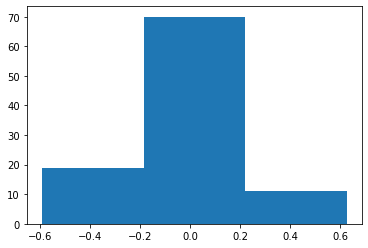

In [70]:
plt.hist(RC.b, bins=3)

In [60]:
RC_sp = ReCom.IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=1e-5, epochs_i=5, eta_s=1e-6, epochs_s=10)
RC_sp.SP_train(train_data, t_points_training, t_listen=5000, reset_M=False)

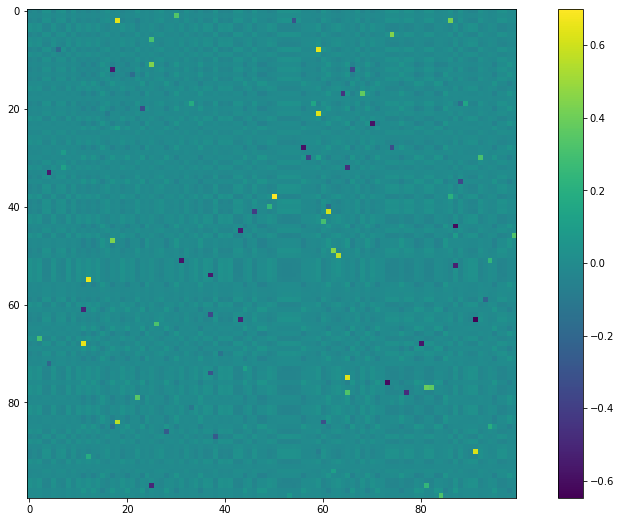

In [61]:
plt.figure(figsize=(15,9))
plt.imshow(RC_sp.M.todense().transpose())
plt.colorbar()

Wall time: 37 s


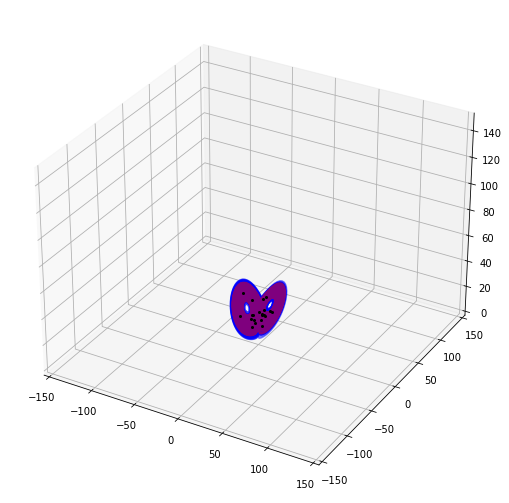

In [76]:
%%time
RC = ReCom.IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=1e-5, epochs_i=5, eta_s=1e-7, epochs_s=4)
RC.IP_train(train_data, t_points_training, t_listen=5000, reset_M=False)
RC.SP_train(train_data, t_points_training, t_listen=5000, reset_M=False)
training_traj = RC.train(train_data, t_points_training, t_listen=5000)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))
trajectories = evolve(RC, ics, t_points_prediction)
plot_traj(trajectories, t_start=1000, t_end=15000, xlim=150, ylim=150, zlim=150)